In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [4]:
data = pd.read_csv('../../../data/processed.cleveland.data.csv')

## Drop categorical features
## Drop NULL values
data = data.dropna()


## calculate mean of age column
mean = data.loc[:,"age"].mean()
data['age'] = np.where(data['age'] >= mean, 0, 1)

## Make goal column binary
data['Probability'] = np.where(data['Probability'] > 0, 1, 0)

protected_attribute = 'age'

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

(dataset_orig.head(5))

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Probability
0,1.0,1.0,0.000000,0.481132,0.244292,1.0,1.0,0.603053,0.0,0.370968,1.0,0.000000,0.75,0.0
1,1.0,1.0,1.000000,0.622642,0.365297,0.0,1.0,0.282443,1.0,0.241935,0.5,1.000000,0.00,1.0
2,1.0,1.0,1.000000,0.245283,0.235160,0.0,1.0,0.442748,1.0,0.419355,0.5,0.666667,1.00,1.0
3,0.0,1.0,0.666667,0.339623,0.283105,0.0,0.0,0.885496,0.0,0.564516,1.0,0.000000,0.00,0.0
4,0.0,0.0,0.333333,0.339623,0.178082,0.0,1.0,0.770992,0.0,0.225806,0.0,0.000000,0.00,0.0


In [5]:
# This dataset size is very small. So repeating it to make it bigger

dataset_orig = pd.concat([dataset_orig]*5, ignore_index=True)
dataset_orig_male , dataset_orig_female = [x for _, x in dataset_orig.groupby(dataset_orig[protected_attribute] == 0)]

# Fairway¶

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy
protected_attribute = 'age'

dataset_orig_train,dataset_orig_test = train_test_split(dataset_orig,test_size=0.2,random_state=0)
X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']


dataset_orig_male , dataset_orig_female = [x for _, x in dataset_orig_train.groupby(dataset_orig_train[protected_attribute] == 0)]
dataset_orig_male[protected_attribute] = 0
X_train_male, y_train_male = dataset_orig_male.loc[:, dataset_orig_male.columns != 'Probability'], dataset_orig_male['Probability']
clf_male = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_male.fit(X_train_male, y_train_male)
X_train_female, y_train_female = dataset_orig_female.loc[:, dataset_orig_female.columns != 'Probability'], dataset_orig_female['Probability']
clf_female = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
clf_female.fit(X_train_female, y_train_female)

for index,row in dataset_orig_train.iterrows():
    row_ = [row.values[0:len(row.values)-1]]
    y_male = clf_male.predict(row_)
    y_female = clf_female.predict(row_)
    if y_male[0] != y_female[0]:        
        dataset_orig_train = dataset_orig_train.drop(index)

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

aod :age -0.09
eod :age -0.03
SPD: 0.28
DI: 0.51
aod :age -0.08
eod :age -0.03
SPD: 0.26
DI: 0.49


# Graph

In [31]:
causal_graph = """
digraph {
age;
cp;
sex;
exang;
Probability;
U[label="Unobserved Confounders"];
sex -> Probability;
age -> thalch; thalch -> Probability;
age -> cp; cp -> Probability
age -> exang; exang -> Probability;
thal -> Probability;
age -> Probability;
U->age;U->Probability;
}
"""

## dowhy works for binary inputs only
dataset_orig_train['Probability'] = np.where(dataset_orig_train['Probability'] == 0, False, True)
dataset_orig_train[protected_attribute] = np.where(dataset_orig_train[protected_attribute] == 1, True, False)

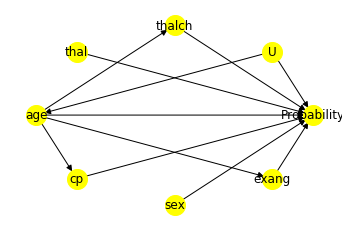

In [32]:
# With graph
model=CausalModel(
        data = dataset_orig_train,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [33]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                      
──────(Expectation(Probability|sex,thal))
d[age]                                   
Estimand assumption 1, Unconfoundedness: If U→{age} and U→Probability then P(Probability|age,sex,thal,U) = P(Probability|age,sex,thal)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [34]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                      
──────(Expectation(Probability|sex,thal))
d[age]                                   
Estimand assumption 1, Unconfoundedness: If U→{age} and U→Probability then P(Probability|age,sex,thal,U) = P(Probability|age,sex,thal)

## Realized estimand
b: Probability~age+sex+thal
Target units: ate

## Estimate
Mean value: 0.20185995154473893

Causal Estimate is 0.20185995154473893


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [39]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:-0.23939477723709507
New effect:-0.282553182879838



# Replace Treatment with Placebo

In [19]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:-0.39496124031007745
New effect:0.0037552081282760967
p value:0.45



# Remove Random Subset of Data

In [40]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:-0.23939477723709507
New effect:-0.24064630400300774
p value:0.48

